In [1]:
import json
import pandas as pd
import statistics
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## Loading the data

In [2]:
def parse_json_to_df(file_path):
    """Parse JSON file to create a pandas dataframe.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        pandas.DataFrame: The dataframe created from the JSON data.
    """
    dfs = []
    
    with open(file_path) as json_file:
        json_data = json.load(json_file)
        
    # Extract the necessary data from the JSON data
    result_data = json_data["results"]
    key_data = result_data.get("root_node", {})
    crowds = key_data.get("results", {})

    # Convert each crowd's data to a dataframe and append to a list
    for crowd_id, value in crowds.items():
        crowd_results = value["results"]
        dfs.append(pd.json_normalize(crowd_results))

    # Combine all the dataframes into a single dataframe
    final_df = pd.concat(dfs)
    
    final_df.reset_index(inplace=True, drop=True)

    return final_df


def parse_ref_json_df(file_path):
    """Parse reference data in JSON format to create a pandas dataframe.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        pandas.DataFrame: The dataframe created from the reference JSON data.
    """
    img_numbers = []
    outcomes = []
    
    # Open the JSON file
    with open(file_path) as json_file:
        json_data = json.load(json_file)
        
    # Extract the necessary data from the JSON data
    for img_id, response in json_data.items():
        img_numbers.append(img_id)
        for question, answer in response.items():
            outcomes.append(answer)
    
    # Create a dataframe from the extracted data
    return pd.DataFrame({"img_number": img_numbers, "outcome": outcomes})

## Combining the datasets

In [3]:
# extracting image number from url in annotation data to combine with reference data
def get_img_num(item):
    """Extract the image number from a string containing the image filepath.

    Args:
        item (str): The filepath string containing the image number.

    Returns:
        str: The extracted image number.
    """
    # Use regex to match the image number
    pattern = r"img_(\d+)\.jpg"
    match = re.search(pattern, item)
    
    # If a match is found, return the extracted image number
    if match:
        return f"img_{match.group(1)}"
    else:
        return None
    
#addings tags comparing annotation results with outcomes in reference data
def get_result_tags(row):
    if row["annotation_result"] == row["outcome"]:
        return "correctly_identified"
    return "error_made"

import pandas as pd

def get_clean_merged_df(annotation_df, reference_df):
    # Add img_number column to annotation_df
    annotation_df["img_number"] = annotation_df["task_input.image_url"].apply(get_img_num)

    # Merge annotation_df and reference_df on img_number column
    merged_data = pd.merge(annotation_df[["user.vendor_user_id", "img_number", "task_output.answer", 
                                           "task_output.cant_solve", "task_output.corrupt_data", 
                                           "task_output.duration_ms"]],
                           reference_df,
                           on="img_number",
                           how="left")

    # few annotations had negative time so deleting those
    merged_data = merged_data[merged_data["task_output.duration_ms"] > 0]

    # annotation instances where one task given to same annotator producing same results more than once, removing those
    merged_data = merged_data.drop_duplicates(subset=["img_number", "user.vendor_user_id", 
                                                      "task_output.answer", "outcome"])

    merged_data["task_output.answer"] = merged_data["task_output.answer"].apply(lambda x: False if x == "no" else True)
    merged_data["task_output.duration_ms"] = merged_data["task_output.duration_ms"].apply(lambda x:  x/1000)
    merged_data = merged_data.rename(columns = {"user.vendor_user_id": "annotator_num", 
                                                "task_output.answer": "annotation_result",
                                                "task_output.cant_solve": "annotation_cant_solve",
                                                "task_output.corrupt_data": "annotation_corrupt_data",
                                                "task_output.duration_ms": "annotation_duration"})

    # Add result_tag column
    merged_data["result_tag"] = merged_data.apply(get_result_tags, axis=1)

    return merged_data


## Analyzing different annotators

In [4]:
def get_annotator_df(df):
    """
    Calculates performance metrics for each annotator in the input dataframe.

    Args:
    - df: pandas DataFrame containing the annotation data.

    """
    annotator_list = []
    total_images = []
    correctly_identified = []
    overall_accuracy = []
    avg_time = []
    min_time = []
    max_time = []

    # Iterate over the unique annotator IDs in the dataframe
    for item in df["annotator_num"].unique():
        # Get a subset of the dataframe for each annotator
        df_ = df[df["annotator_num"] == item]
        
        total_images.append(df_.shape[0])

        # Calculate the number of correctly identified images for the annotator
        df1 = df_[df_["annotation_result"] == df_["outcome"]]
        correctly_identified.append(df1.shape[0])
        
        # Calculate the overall accuracy for the annotator
        overall_accuracy.append(df1.shape[0] / df_.shape[0] if df_.shape[0] > 0 else 0)

        # Calculate the average, minimum and maximum time taken by the annotator to annotate an image
        avg_time.append(df_["annotation_duration"].mean())
        min_time.append(df_["annotation_duration"].min())
        max_time.append(df_["annotation_duration"].max())

        # Add the annotator ID to the list
        annotator_list.append(item)

    return pd.DataFrame({
        "annotator_num": annotator_list, 
        "total_images": total_images, 
        "correctly_identified": correctly_identified, 
        "overall_accuracy": overall_accuracy,
        "avg_time": avg_time, 
        "min_time": min_time, 
        "max_time": max_time
    })

## Analyzing different Images

In [5]:
def get_img_df(df):
    # initialize lists for each feature
    img_list = []
    correctly_identified = []
    error_made = []
    avg_time = []
    good_annotator_list = []
    bad_annotator_list = []
    
    # loop over unique image numbers in the dataframe
    for item in list(df["img_number"]):
        if item not in img_list:
            img_list.append(item)
            
            # create a new dataframe with only the rows corresponding to the current image number
            df_ = df[df["img_number"] == item]
            
            # calculate the number of times the image was correctly identified
            df1 = df_[df_["annotation_result"] == df_["outcome"]]
            correctly_identified.append(df1.shape[0])
            
            # calculate the number of times an error was made when annotating the image
            df2 = df_[df_["annotation_result"] != df_["outcome"]]
            error_made.append(df2.shape[0])
            
            # calculate the average duration of annotations for the image
            avg_time.append(df_["annotation_duration"].mean())
            
            # create a list of annotators who correctly identified the image
            good_annotator_list.append(list(df1["annotator_num"].unique()))

            # create a list of annotators who made errors when annotating the image
            bad_annotator_list.append(list(df2["annotator_num"].unique()))
            
    return pd.DataFrame({
        "img_number": img_list, 
        "correctly_identified": correctly_identified, 
        "error_made": error_made, 
        "avg_time": avg_time, 
        "good_annotator_list": good_annotator_list, 
        "bad_annotator_list": bad_annotator_list
    })



def tag_images(item):
    """
    This function tags images based on the number of times they were correctly identified by annotators.The image tag is assigned based on the number of correct identifications by annotators. This tagging can be useful in identifying which images are the most challenging for annotators, 
    and can be used to guide the development of better annotation tools and workflows.
    
    Parameters:
    item (int): The number of times an image was correctly identified by annotators.
    
    Returns:
    str: The tag for the image based on the number of correct identifications.
    
    """
    if item==0:
        return "quite easy"    
    if item >0 and item <3:
        return "easy"
    if item >=3 and item <7:
        return "highly disagreeable"
    if item >=7 and item <10:
        return "difficult"
    return "very difficult"

## Getting combined weighted accuracy for "easy", "highly disagreeable" , "difficult" images

In [6]:
def get_annotator_accuracy(img_df, annotation_df):
    """
    Calculates the accuracy of each annotator for different image categories based on the annotations 
    recorded in the annotation_df dataframe and the image categories in the img_df dataframe. 
    
    Parameters:
    -----------
    img_df: pandas.DataFrame
        A dataframe containing information about images and their categories. This dataframe must have 
        the following columns: 'img_list', 'img_category', 'good_annotator_list', 'bad_annotator_list'.
    annotation_df: pandas.DataFrame
        A dataframe containing information about the annotations provided by different annotators. This 
        dataframe must have the following columns: 'annotator_list', 'total_images', 'correctly_identified', 
        'overall_accuracy', 'avg_time', 'min_time', 'max_time'.
        
    Returns:
    --------
    pandas.DataFrame
        A dataframe with one row per annotator, containing their accuracy and the number of images they 
        annotated for each image category. The columns are named as 'easy_accuracy', 'num_of_easy_images', 
        'highly_disagreeable_accuracy', 'num_of_highly_disagreeable_images', 'difficult_accuracy', 
        'num_of_difficult_images'.
    """
        
    # list of image categories
    category_list = list(img_df[img_df["img_category"].isin(["easy","highly disagreeable", "difficult"])]["img_category"].unique())
    
    # list to store accuracy dataframes for each category
    accuracies = []
    
    # iterate over each category and calculate the accuracy for each annotator
    for item in category_list:
        
        # initialize defaultdicts to store good/bad results and total images for each annotator
        annotator_good_results = defaultdict(lambda:0)
        annotator_bad_results = defaultdict(lambda:0)
        annotator_total_results = defaultdict(lambda: 0)
        total_images_category = defaultdict(lambda: 0)
        
        # filter images for current category
        df_ = img_df[img_df["img_category"]== item]
        
        # count the number of good/bad results for each annotator
        for item1 in df_["good_annotator_list"]:
            for item_ in item1:
                annotator_good_results[item_] +=1
        for item2 in df_["bad_annotator_list"]:
            for item_ in item2:
                annotator_bad_results[item_] +=1
        
        # calculate total images and accuracy for each annotator
        for item3 in list(annotation_df["annotator_num"]):
            total_images_category[item3] = annotator_good_results.get(item3,0)+ annotator_bad_results.get(item3,0)
            annotator_total_results[item3] = annotator_good_results.get(item3,0)/total_images_category.get(item3,1) if total_images_category.get(item3,0) != 0 else 0
        
        # create dataframe with accuracy and total images for each annotator for current category
        data = pd.DataFrame([annotator_total_results,total_images_category]).T
        data.columns = [ f"{item}_accuracy",f"num_of_{item}_images"]
        
        # append dataframe to list of accuracy dataframes
        accuracies.append(data)
    
    # concatenate accuracy dataframes and return
    result = pd.concat(accuracies, axis = 1)
    return result


#getting combined weighted accuracy for above categories
def get_combined_accuracies(row):
    easy_a = (row["easy_accuracy"]*row["num_of_easy_images"])  
    diff_a = (row["difficult_accuracy"]*row["num_of_difficult_images"])  
    dis_a = (row["highly disagreeable_accuracy"]*row["num_of_highly disagreeable_images"])
    total_images = row["num_of_easy_images"]+ row["num_of_difficult_images"]+row["num_of_highly disagreeable_images"]
    
    combined_accuracy = (easy_a + diff_a + dis_a)/total_images
    
    return combined_accuracy

def compute_combined_weighted_accuracies(img_analyze_data,anno_analyze_data):
    x = get_annotator_accuracy(img_analyze_data, anno_analyze_data)
    x["combined_accuracy"] = x.apply(get_combined_accuracies, axis = 1)
    #x = x.reset_index()
    return x
    
    
    
    
    

## Getting how many annotators agree with particular annotator on average

In [7]:
from collections import defaultdict

def compute_annotator_agreement1(df):
    """
    Calculates the agreement of each annotator across all images based on the annotations 
    recorded in the input dataframe. The agreement is defined as the average number of 
    annotators who provided the same annotation for each image.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        A dataframe containing the annotations provided by different annotators. This 
        dataframe must have the following columns: 'good_annotator_list', 'bad_annotator_list'.
        
    Returns:
    --------
    pandas.DataFrame
        A dataframe with one row per annotator, containing their agreement score. The columns 
        are named as 'annotator_agreement'.
    """
    # Create a dictionary to store the agreement of each annotator
    annotator_agreement = defaultdict(list)

    # Loop through the two columns containing the good and bad annotations
    for col in ["good_annotator_list", "bad_annotator_list"]:
        for annotations in df[col]:
            # Loop through the annotations and count the number of correct annotators
            for annotator in annotations:
                num_correct_annotators = len(annotations)
                annotator_agreement[annotator].append(num_correct_annotators)

    # Calculate the average agreement for each annotator and round the result to 2 decimal places
    for key, value in annotator_agreement.items():
        annotator_agreement[key] = round(statistics.mean(value), 2)

    # Convert the result to a dataframe and return it
    result = pd.DataFrame.from_dict(annotator_agreement, orient='index', columns=["annotator_agreement"])
    #result = result.reset_index()
    return result


## Merging annotators' info into one dataframe

In [8]:
def merged_annotator_information(anno_analyze_data,anno_combined_accuracy_df,anno_agree_df):
    anno_analyze_data = anno_analyze_data.set_index("annotator_num")
    annotator_df = pd.concat([anno_analyze_data,anno_combined_accuracy_df,anno_agree_df], axis = 1)
    annotator_df = annotator_df.reset_index()
    annotator_df = annotator_df.rename(columns = {"index": "annotator_num"})
    annotator_df["annotator_num"] = annotator_df["annotator_num"].apply(lambda x: x.split("_")[1])
    annotator_df = annotator_df.sort_values(by = "annotator_num")
    return annotator_df

## Data Pipeline

In [9]:
%%time
annotation_df = parse_json_to_df("anonymized_project.json")
reference_df = parse_ref_json_df("references.json")
merged_data = get_clean_merged_df(annotation_df, reference_df)
anno_analyze_data = get_annotator_df(merged_data)
img_analyze_data = get_img_df(merged_data)
img_analyze_data["img_category"] = img_analyze_data["error_made"].apply(tag_images)
anno_combined_accuracy_df = compute_combined_weighted_accuracies(img_analyze_data,anno_analyze_data)
anno_agree_df = compute_annotator_agreement1(img_analyze_data)
annotator_df = merged_annotator_information(anno_analyze_data,anno_combined_accuracy_df,anno_agree_df)

CPU times: user 36.3 s, sys: 299 ms, total: 36.6 s
Wall time: 36.6 s


## Basic statistics

In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72473 entries, 0 to 90869
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   annotator_num            72473 non-null  object 
 1   img_number               72473 non-null  object 
 2   annotation_result        72473 non-null  bool   
 3   annotation_cant_solve    72473 non-null  bool   
 4   annotation_corrupt_data  72473 non-null  bool   
 5   annotation_duration      72473 non-null  float64
 6   outcome                  72473 non-null  bool   
 7   result_tag               72473 non-null  object 
dtypes: bool(4), float64(1), object(3)
memory usage: 3.0+ MB


In [11]:
number_of_annotators = merged_data["annotator_num"].value_counts()
reference_df["outcome"].value_counts()

True     4586
False    4501
Name: outcome, dtype: int64

In [12]:
merged_data["annotation_cant_solve"].value_counts()

False    72456
True        17
Name: annotation_cant_solve, dtype: int64

In [13]:
merged_data["annotation_corrupt_data"].value_counts()

False    72470
True         3
Name: annotation_corrupt_data, dtype: int64

In [14]:
merged_data = pd.merge(merged_data, img_analyze_data[["img_number","img_category"]], on = "img_number", how = "left")

In [15]:
merged_data

,annotator_num,img_number,annotation_result,annotation_cant_solve,annotation_corrupt_data,annotation_duration,outcome,result_tag,img_category
0,annotator_12,img_4686,False,False,False,0.997,False,correctly_identified,quite easy
1,annotator_11,img_4686,False,False,False,0.845,False,correctly_identified,quite easy
2,annotator_22,img_4686,False,False,False,1.468,False,correctly_identified,quite easy
3,annotator_17,img_4686,False,False,False,1.062,False,correctly_identified,quite easy
4,annotator_02,img_4686,False,False,False,0.879,False,correctly_identified,quite easy
...,...,...,...,...,...,...,...,...,...
72468,annotator_16,img_2866,True,False,False,1.620,True,correctly_identified,quite easy
72469,annotator_08,img_2866,True,False,False,1.130,True,correctly_identified,quite easy
72470,annotator_12,img_2866,True,False,False,2.690,True,correctly_identified,quite easy
72471,annotator_04,img_2866,True,False,False,1.306,True,correctly_identified,quite easy


In [16]:
merged_data[merged_data["annotation_corrupt_data"]]["annotator_num"].value_counts()

annotator_18    2
annotator_08    1
Name: annotator_num, dtype: int64

In [17]:
merged_data[merged_data["annotation_cant_solve"]]["annotator_num"].value_counts()

annotator_22    4
annotator_04    4
annotator_08    2
annotator_02    2
annotator_18    1
annotator_11    1
annotator_07    1
annotator_14    1
annotator_20    1
Name: annotator_num, dtype: int64

### Takeaways
- There are 22 annotators
- There are total 9087 images to be annotated
- reference data is fairly balanced
- Each image annotated 10 times
- Annotators do not get same number of annotations, they vary vastly
- no clear pattern in cant solve and corrupt data

## Annotator prediction

In [18]:
# Define the weights for each factor
def make_predictions(annotator_df):
    weight_accuracy = 0.4
    weight_agreement = 0.4
    weight_time = 0.2

    # Combine the factors using weighted sum
    annotator_df["score"] = (weight_accuracy * annotator_df["combined_accuracy"]) + (weight_agreement * annotator_df["annotator_agreement"]) + (weight_time * annotator_df["avg_time"])

    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(annotator_df[["combined_accuracy", "annotator_agreement", "avg_time", "score"]])

    # Cluster the data
    kmeans = KMeans(n_clusters=2, random_state=0)
    clusters = kmeans.fit_predict(data_scaled)
    labels = ["Good" if item == 0 else "Bad" for item in clusters]
    annotator_df["labels"] = labels
    return annotator_df[["annotator_num", "labels"]]

In [18]:
predictions = make_predictions(annotator_df)
predictions.to_csv("predictions.csv", index =False)

## Visualizations

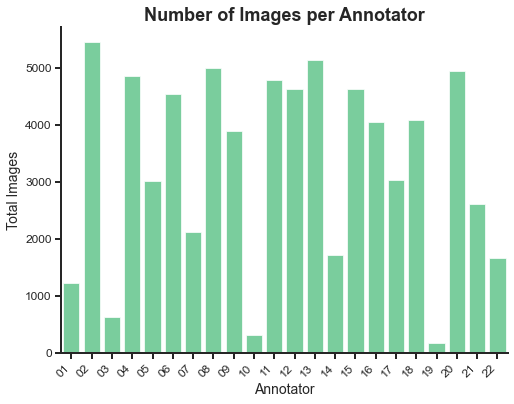

<Figure size 432x288 with 0 Axes>

In [19]:
sns.set(style="ticks", rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x="annotator_num", y="total_images", data=annotator_df, color="#2ecc71", alpha=0.7)
ax.set_title('Number of Images per Annotator', fontsize=18, fontweight='bold')
ax.set_xlabel('Annotator', fontsize=14)
ax.set_ylabel('Total Images', fontsize=14)
ax.tick_params(labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.show()
savefig("image_dist_bicycle.png", transparent = True)

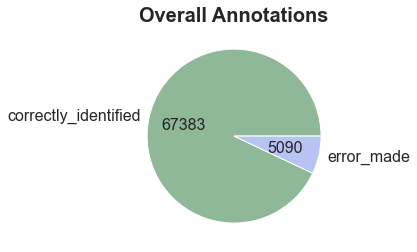

In [20]:
data_pie = pd.DataFrame(merged_data.groupby("result_tag")["result_tag"].count())
data_pie.columns = ["num_of_images"]
palette_color = [ '#8EB897', '#B7C3F3' ]
total = data_pie["num_of_images"].sum()
plt.pie(list(data_pie["num_of_images"]), labels=list(merged_data["result_tag"].unique()),textprops={'fontsize': 16}, colors=palette_color, autopct= lambda p: '{:.0f}'.format(p * total / 100))
plt.rcParams["figure.figsize"] = [15, 8]
plt.title('Overall Annotations', fontsize = 20, fontweight='bold')
savefig("pie_chart_bicycle.png", transparent = True)

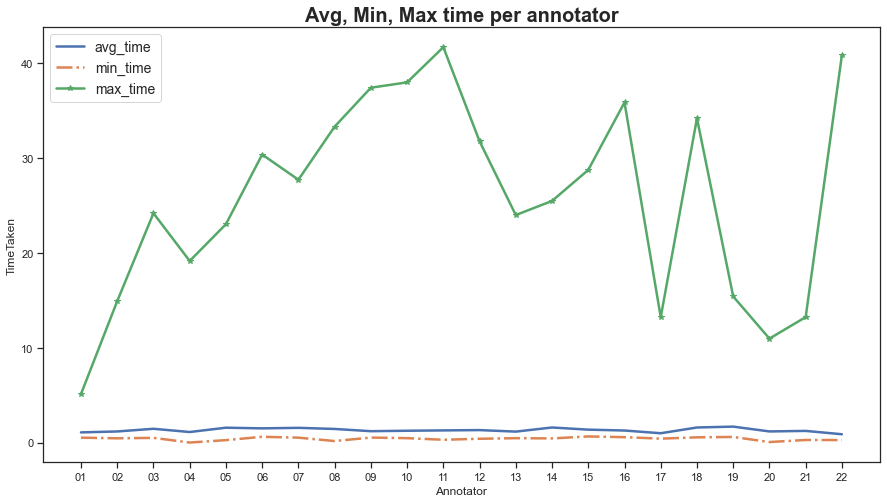

In [21]:
avg_time = plt.plot(list(annotator_df["annotator_num"]), list(annotator_df["avg_time"]))
min_time =plt.plot(list(annotator_df["annotator_num"]), list(annotator_df["min_time"]), '-.')
max_time = plt.plot(list(annotator_df["annotator_num"]), list(annotator_df["max_time"]), '-*')
plt.xlabel("Annotator")
plt.ylabel("TimeTaken")

plt.legend(["avg_time", "min_time", "max_time"], fontsize = 14)
plt.title('Avg, Min, Max time per annotator', fontsize = 20, fontweight='bold')
plt.show()

In [25]:
img_time = pd.DataFrame(merged_data.groupby("img_category")["annotation_duration"].mean())
img_time = img_time.reset_index()

Text(0.5, 1.0, 'Avg time taken image category wise')

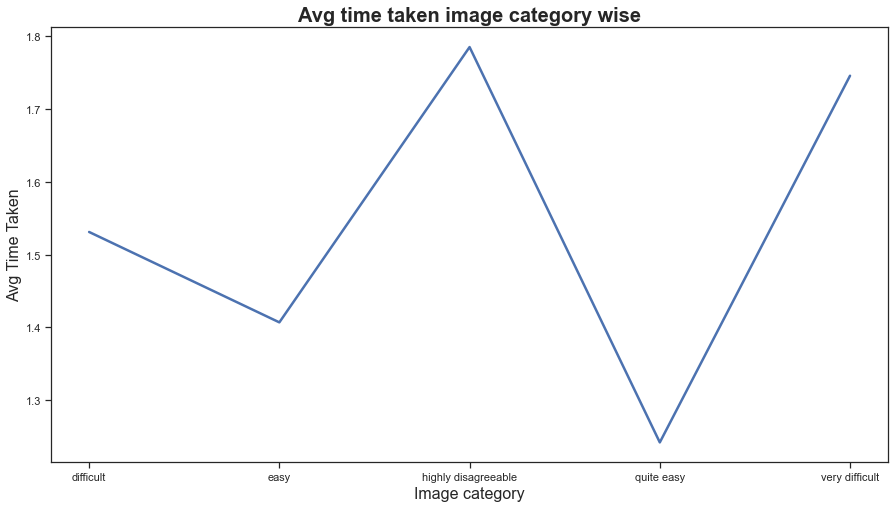

In [26]:
plt.plot(list(img_time["img_category"]), list(img_time["annotation_duration"]))
plt.xlabel("Image category", fontsize = 16)
plt.ylabel("Avg Time Taken", fontsize = 16)
plt.title('Avg time taken image category wise', fontsize = 20, fontweight='bold')

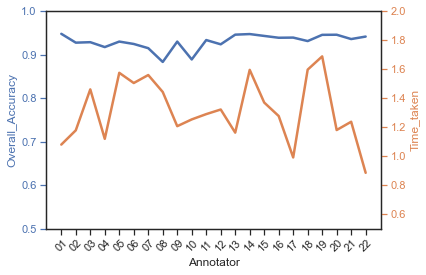

In [26]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111, label="1")
ax.plot(list(annotator_df["annotator_num"]), list(annotator_df["overall_accuracy"]), color="C0")

ax.set_xlabel("Annotator")
ax.set_ylabel("Overall_Accuracy", color="C0")
ax.tick_params(axis='y', colors="C0")
ax.tick_params(axis='x', rotation=45)
ax.axis(ymin=0.5, ymax=1)

ax2 = ax.twinx()
ax2.plot(list(annotator_df["annotator_num"]), list(annotator_df["avg_time"]), color="C1")
ax2.set_ylabel("Time_taken", color="C1")
ax2.tick_params(axis='y', colors="C1")
ax2.axis(ymin=0.5, ymax=2)

plt.show()

In [27]:
img_data_plot = pd.DataFrame(img_analyze_data.groupby("img_category")["img_category"].count())
img_data_plot.columns = [ "number_of_images"]
img_data_plot = img_data_plot.sort_values(by = "number_of_images", ascending = False )
img_data_plot = img_data_plot.reset_index()

Text(0.5, 1.0, 'Number of Images per Category')

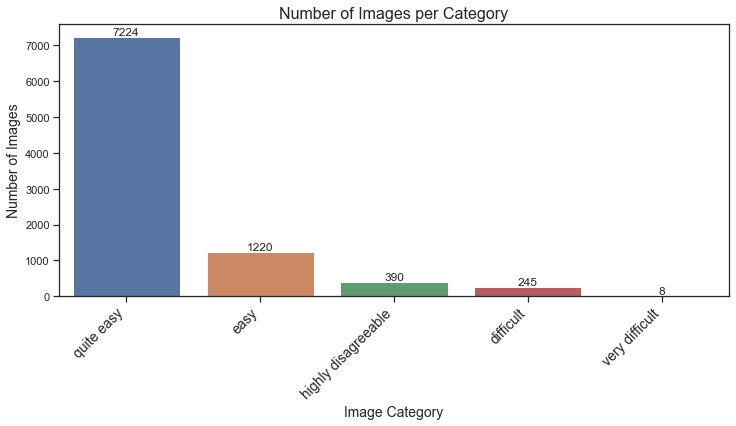

In [28]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(x='img_category', y='number_of_images', data=img_data_plot)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize = 14)
#ax.text(y = "number_of_images", x = "image_category", s = ,ha="center", va="bottom")
ax.set_xlabel('Image Category', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, int(height),
                ha="center", va="bottom")
ax.set_title('Number of Images per Category', fontsize=16)


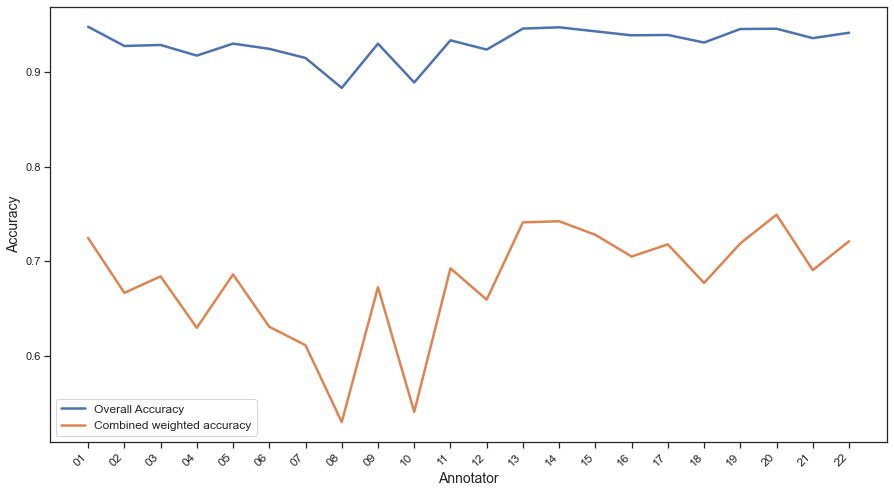

In [29]:
n = len(annotator_df.index)
colors = cm.rainbow(np.linspace(0, 1, n))

plt.plot(list(annotator_df['annotator_num']), list(annotator_df["overall_accuracy"]), label='Overall Accuracy')
plt.plot(list(annotator_df["annotator_num"]), list(annotator_df["combined_accuracy"]), label="Combined weighted accuracy")
plt.rcParams["figure.figsize"] = (10,4)
plt.xlabel("Annotator", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.legend(fontsize=12)
plt.show()

Text(0, 0.5, 'Num_of_annotators_in_agreement')

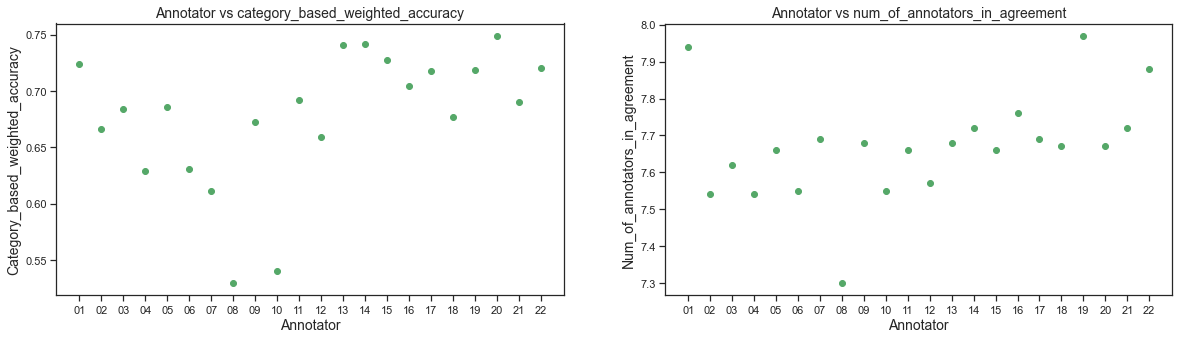

In [30]:
data_accuracy_scatter = annotator_df.sort_values(by = "combined_accuracy")
data_agreement_scatter = annotator_df.sort_values(by = "annotator_agreement")
n = len(annotator_df.index)
#colors = cm.rainbow(np.linspace(0, 1, n))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax[0].scatter(annotator_df.annotator_num,annotator_df.combined_accuracy, c = "g")
ax[0].set_title("Annotator vs category_based_weighted_accuracy", fontsize = 14)
ax[0].set_xlabel("Annotator", fontsize = 14)
ax[0].set_ylabel("Category_based_weighted_accuracy", fontsize = 14)

ax[1].scatter(annotator_df.annotator_num,annotator_df.annotator_agreement, c = "g")
ax[1].set_title("Annotator vs num_of_annotators_in_agreement", fontsize = 14)
ax[1].set_xlabel("Annotator", fontsize = 14)
ax[1].set_ylabel("Num_of_annotators_in_agreement", fontsize = 14)

In [31]:
annotator_df.to_csv("annotator_df.csv")

In [32]:
merged_data

,annotator_num,img_number,annotation_result,annotation_cant_solve,annotation_corrupt_data,annotation_duration,outcome,result_tag,img_category_x,img_category_y
0,annotator_12,img_4686,False,False,False,0.997,False,correctly_identified,quite easy,quite easy
1,annotator_11,img_4686,False,False,False,0.845,False,correctly_identified,quite easy,quite easy
2,annotator_22,img_4686,False,False,False,1.468,False,correctly_identified,quite easy,quite easy
3,annotator_17,img_4686,False,False,False,1.062,False,correctly_identified,quite easy,quite easy
4,annotator_02,img_4686,False,False,False,0.879,False,correctly_identified,quite easy,quite easy
...,...,...,...,...,...,...,...,...,...,...
72468,annotator_16,img_2866,True,False,False,1.620,True,correctly_identified,quite easy,quite easy
72469,annotator_08,img_2866,True,False,False,1.130,True,correctly_identified,quite easy,quite easy
72470,annotator_12,img_2866,True,False,False,2.690,True,correctly_identified,quite easy,quite easy
72471,annotator_04,img_2866,True,False,False,1.306,True,correctly_identified,quite easy,quite easy
